In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import sys
sys.path.append(os.path.abspath('../'))
import utils.dataset_loader as dl
import utils.analysis as analysis
import utils.compute as compute

In [2]:
# Paths 
DATASETS_PATH = '../datasets'

In [3]:
# Dataset paths
datasets = {
    "random_dataset": "random_dataset",
}

In [4]:
# Load all datasets with caching
loaded_datasets = {
    name: dl.load_dataset_files_with_cache(path, cache_path=f"{DATASETS_PATH}/cache/{name}_cache.pkl")
    for name, path in datasets.items()
}

Checking for cache at: ../datasets/cache/random_dataset_cache.pkl
Loading datasets from cache: ../datasets/cache/random_dataset_cache.pkl


In [5]:
AES_SBOX = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5,
    0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0,
    0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC,
    0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A,
    0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0,
    0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B,
    0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85,
    0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5,
    0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17,
    0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88,
    0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C,
    0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9,
    0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6,
    0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E,
    0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94,
    0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68,
    0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
], dtype=np.uint8)


### Hypothesis
We hypothesize that the power consumption traces recorded during AES encryption contain
statistically significant leakage points that correlate with cryptographic intermediate values.
To validate this, we will analyze the traces using two techniques:
- **Signal-to-Noise Ratio (SNR)** grouped by SBox output
- **Pearson correlation** with the Hamming weight of the SBox output


In [6]:
# Load the dataset
random_dataset = loaded_datasets['random_dataset']

# Get the trace matrix
traces = dl.get_trace_matrix(random_dataset)  # shape (n_traces, n_samples)

# Get plaintexts and keys
plaintexts_values = random_dataset['plaintexts'].values
keys_values = random_dataset['keys'].values

# Convert each plaintext/key string to a list of 16 ASCII byte values
plaintexts = np.array([list(p[0].encode('utf-8')) for p in plaintexts_values], dtype=np.uint8)
keys = np.array([list(k[0].encode('utf-8')) for k in keys_values], dtype=np.uint8)

# Confirm shapes (should be: n_traces x 16)
print("Plaintexts shape:", plaintexts.shape)
print("Keys shape:", keys.shape)


Plaintexts shape: (10000, 16)
Keys shape: (10000, 16)


In [7]:
traces

array([[-0.01757812, -0.08105469,  0.13085938, ..., -0.15820312,
        -0.09375   ,  0.04882812],
       [-0.01855469, -0.078125  ,  0.13085938, ..., -0.15722656,
        -0.09375   ,  0.04882812],
       [-0.01660156, -0.07714844,  0.12695312, ..., -0.15527344,
        -0.08691406,  0.04980469],
       ...,
       [-0.01953125, -0.08105469,  0.13085938, ..., -0.15527344,
        -0.09082031,  0.04882812],
       [-0.015625  , -0.07714844,  0.12890625, ..., -0.15527344,
        -0.08984375,  0.04589844],
       [-0.01660156, -0.078125  ,  0.12988281, ..., -0.15722656,
        -0.09082031,  0.046875  ]])

In [8]:
plaintexts

array([[101,  56, 101, ...,  52,  49,  52],
       [100,  99,  54, ...,  57,  97,  53],
       [ 56,  57,  51, ..., 102,  56,  55],
       ...,
       [ 53,  49,  56, ...,  53,  54,  48],
       [ 99,  48,  53, ...,  55,  98, 100],
       [ 55,  49, 100, ...,  56,  48,  98]], dtype=uint8)

In [9]:
keys

array([[ 54,  53, 100, ...,  99, 101,  55],
       [100,  56,  99, ...,  53,  54, 100],
       [ 50,  50, 102, ..., 100, 102, 100],
       ...,
       [ 54,  98,  97, ..., 100, 100,  55],
       [102,  98,  48, ..., 101,  99,  53],
       [ 57, 101,  99, ...,  54,  54,  49]], dtype=uint8)

In [10]:
sbox_outputs = compute._aes_sbox_output_byte(plaintexts, keys, byte=0, AES_SBOX=AES_SBOX)

In [11]:
sbox_outputs

array([237,  99, 103, ..., 123, 107, 171], dtype=uint8)

In [12]:
snr = compute._snr(traces, sbox_outputs, num_classes=256)

In [13]:
correlation = compute._correlation(traces, sbox_outputs)

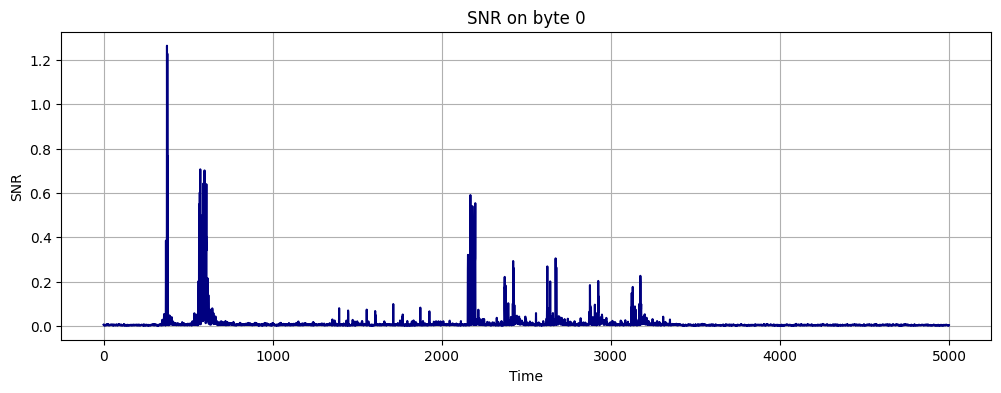

In [14]:

plt.figure(figsize=(12, 4))
plt.plot(snr, color='navy')
plt.title("SNR on byte 0")
plt.xlabel("Time")
plt.ylabel("SNR")
plt.grid(True)
plt.show()

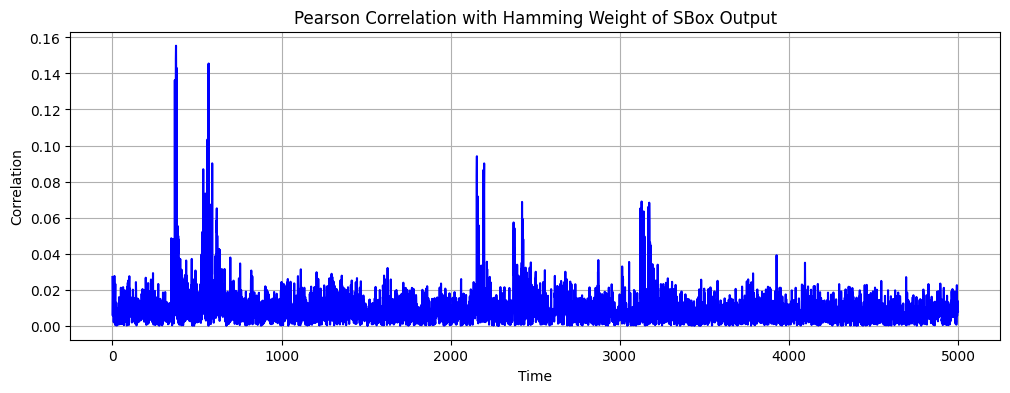

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(correlation, label='Correlation with SBox output byte 0', color='blue')
plt.title('Pearson Correlation with Hamming Weight of SBox Output')
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

In [16]:
top_pois_snr = np.where(snr > 0.2)[0]
print("Top Points of Interest (sample indices):", top_pois_snr)

Top Points of Interest (sample indices): [ 369  373  375  376  377  380  562  565  567  568  569  570  571  572
  582  584  586  588  589  590  597  599  606  607  608  615 2154 2155
 2169 2171 2181 2182 2186 2193 2194 2196 2197 2198 2372 2422 2426 2624
 2641 2673 2677 2925 3174]


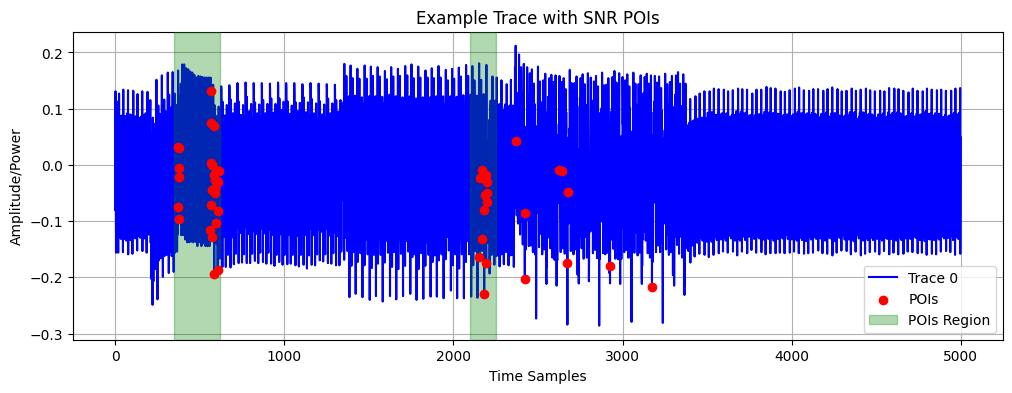

In [17]:
plt.figure(figsize=(12, 4))
plt.plot(traces[0], label="Trace 0", color='blue')
plt.scatter(top_pois_snr, traces[0][top_pois_snr], color='red', label="POIs", zorder=4)
plt.title("Example Trace with SNR POIs")

plt.xlabel("Time Samples")
plt.ylabel("Amplitude/Power")

plt.axvspan(350, 620, color='green', alpha=0.3, label="POIs Region", zorder=3)
plt.axvspan(2100, 2250, color='green', alpha=0.3, zorder=3)
plt.legend()
plt.grid(True)
plt.show()

In [18]:
top_pois_snr_hw = np.where(correlation > 0.055)[0]  # Top POIs
print("Top Points of Interest Correlation(sample indices):", top_pois_snr_hw)

Top Points of Interest Correlation(sample indices): [ 369  373  375  376  377  380  387  537  549  561  562  565  566  567
  569  586  588  590  615  617 2154 2155 2157 2159 2167 2194 2196 2197
 2198 2372 2422 2426 3121 3129 3141 3169 3174]


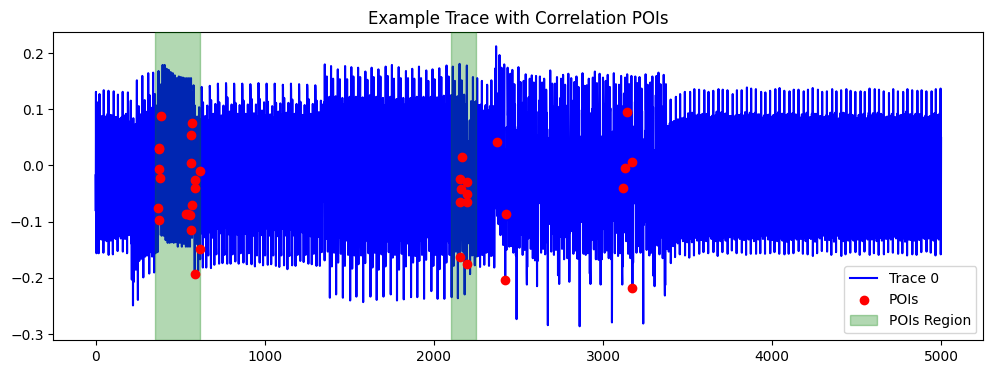

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(traces[0], label="Trace 0", color='blue')
plt.scatter(top_pois_snr_hw, traces[0][top_pois_snr_hw], color='red', label="POIs", zorder=5)
plt.title("Example Trace with Correlation POIs")
plt.axvspan(350, 620, color='green', alpha=0.3, label="POIs Region", zorder=3)
plt.axvspan(2100, 2250, color='green', alpha=0.3, zorder=3)
plt.legend()
plt.show()

In [20]:
result_aes = analysis.analyze_leakage_all_nibbles(traces, plaintexts, keys, AES_SBOX, top_k=3)


 Analyzing byte 0...


  Top SNR POIs: [377 590 375], values: [0.46502583 0.46397261 0.45923984]
  Top Corr POIs: [377 375 373], values: [0.18266598 0.17105536 0.15571041]

 Analyzing byte 1...
  Top SNR POIs: [2144 2143  645], values: [0.61194929 0.51697436 0.50617531]
  Top Corr POIs: [365 368 363], values: [0.15885842 0.15085746 0.14614246]

 Analyzing byte 2...
  Top SNR POIs: [2089  693  686], values: [0.64485465 0.48191063 0.36471233]
  Top Corr POIs: [354 356 355], values: [0.13879343 0.1350503  0.12492469]

 Analyzing byte 3...
  Top SNR POIs: [ 741  734 2035], values: [0.45537605 0.4468288  0.39177492]
  Top Corr POIs: [344 347 345], values: [0.12789874 0.1188294  0.11495882]

 Analyzing byte 4...
  Top SNR POIs: [1981  789 1985], values: [0.7376333  0.47808525 0.45608285]
  Top Corr POIs: [333 329 335], values: [0.16136746 0.12118355 0.11749111]

 Analyzing byte 5...
  Top SNR POIs: [1929  837  830], values: [0.64747225 0.49968028 0.40048389]
  Top Corr POIs: [322 321 326], values: [0.13280399 0.12

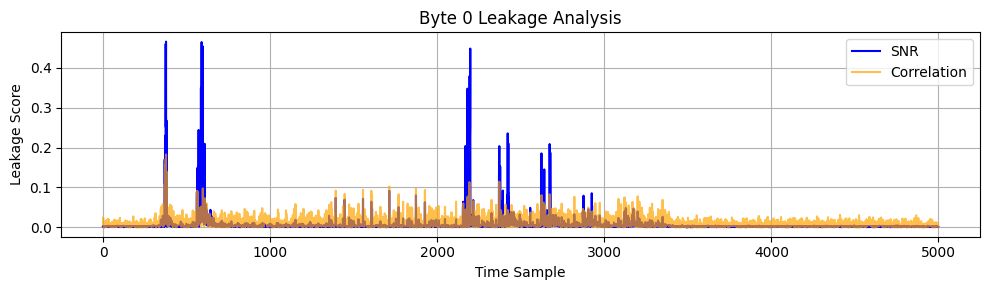

In [21]:
for byte in range(1):
    plt.figure(figsize=(10, 3))
    plt.plot(result_aes[byte]['snr'], label='SNR', color='blue')
    plt.plot(result_aes[byte]['correlation'], label='Correlation', color='orange', alpha=0.7)
    plt.title(f'Byte {byte} Leakage Analysis')
    plt.xlabel('Time Sample')
    plt.ylabel('Leakage Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

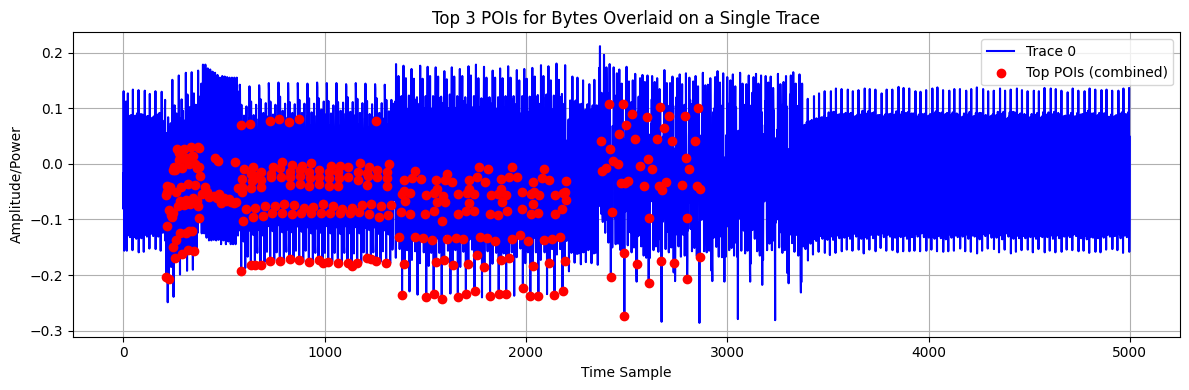

In [22]:
# Choose one trace to highlight POIs on
trace_index = 0
trace = traces[trace_index]

# Collect all top 3 POIs from each nibble's SNR
poi_indices = []
for byte in range(16):
    top_pois_snr = np.where(result_aes[byte]['snr'] > 0.15)[0]
    top_pois_corr = np.where(result_aes[byte]['correlation'] > 0.65)[0]
    # top_pois_snr = np.argsort(result_aes[byte]['snr'])[-25:]  # Top 10
    # top_pois_corr = np.argsort(result_aes[byte]['correlation'])[-40:]  # Top 10
    poi_indices.extend(top_pois_snr)
    poi_indices.extend(top_pois_corr)

# Remove duplicates and sort
poi_indices = sorted(set(poi_indices))

# Plot the trace
plt.figure(figsize=(12, 4))
plt.plot(trace, label=f"Trace {trace_index}", color='blue')

# Mark POIs
plt.scatter(poi_indices, trace[poi_indices], color='red', zorder=5, label="Top POIs (combined)")
plt.title("Top 3 POIs for Bytes Overlaid on a Single Trace")
plt.xlabel("Time Sample")
plt.ylabel("Amplitude/Power")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
def export_sbox_and_labels_per_nibble(sbox_outputs, dataset_name="aes", base_dir="../dataset"):
    """
    Save cropped traces and SBox labels to a structured directory.
    Also saves per-nibble label arrays.

    Parameters:
        cropped_traces (np.ndarray): shape (n_traces, n_samples)
        sbox_outputs (np.ndarray): shape (n_traces, 16)
        dataset_name (str): name of subfolder to store data
        base_dir (str): root dataset directory (default: "dataset")
    """
    output_dir = os.path.join(base_dir, dataset_name)
    os.makedirs(output_dir, exist_ok=True)

    # Save full label matrix
    np.save(os.path.join(output_dir, "sbox_outputs.npy"), sbox_outputs)

    # Save one label file per nibble
    for nibble in range(sbox_outputs.shape[1]):
        nibble_labels = sbox_outputs[:, nibble]
        nibble_path = os.path.join(output_dir, f"byte_{nibble}_labels.npy")
        np.save(nibble_path, nibble_labels)

    print(f"Exported labels (with per-nibble files) to: {output_dir}")


In [24]:
sbox_outputs = compute._aes_sbox_outputs(plaintexts, keys, AES_SBOX)

In [25]:
export_sbox_and_labels_per_nibble(sbox_outputs, dataset_name="aes")

Exported labels (with per-nibble files) to: ../dataset/aes


In [26]:
global_pois = []

for idx in range(16):

    poi_indices = []

    # High leakegeage nibbles
    # snr_top = np.where(results_present[idx]['snr'] > 0.7)[0]
    # hw_top = np.where(results_present[idx]['correlation'] > 0.9)[0]

    snr_top = np.argsort(result_aes[idx]['snr'])[-35:]
    hw_top = np.argsort(result_aes[idx]['correlation'])[-35:]

    poi_indices.extend(snr_top)
    poi_indices.extend(hw_top)

    global_pois.extend(poi_indices)

    unique_pois = sorted(set(poi_indices))
    print(f"Byte {idx} POIs: {len(unique_pois)}")
    filename = f"../dataset/aes/pois/byte_{idx}_pois.npy"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    np.save(filename, unique_pois)

global_unique_pois = sorted(set(global_pois))
np.save(f"../dataset/aes/pois/global.npy", global_unique_pois)
print(f"Global POIs: {len(global_unique_pois)}")

Byte 0 POIs: 55
Byte 1 POIs: 54
Byte 2 POIs: 60
Byte 3 POIs: 56
Byte 4 POIs: 57
Byte 5 POIs: 54
Byte 6 POIs: 56
Byte 7 POIs: 55
Byte 8 POIs: 56
Byte 9 POIs: 58
Byte 10 POIs: 56
Byte 11 POIs: 55
Byte 12 POIs: 53
Byte 13 POIs: 56
Byte 14 POIs: 58
Byte 15 POIs: 56
Global POIs: 800


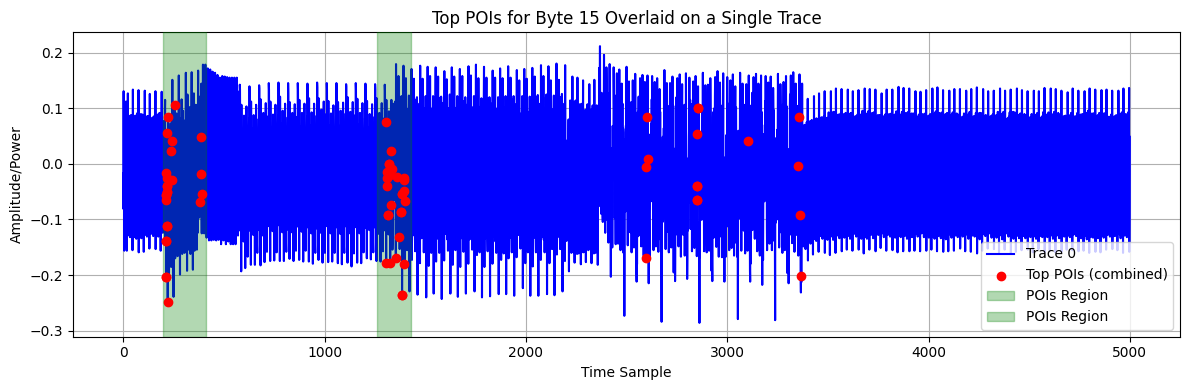

In [27]:
poi_indices = []
byte_idx = 15

snr_top = np.argsort(result_aes[byte_idx]['snr'])[-35:]
hw_top = np.argsort(result_aes[byte_idx]['correlation'])[-35:]

poi_indices.extend(snr_top)
poi_indices.extend(hw_top)

global_pois.extend(poi_indices)

unique_pois = sorted(set(poi_indices))

# Plot the trace
plt.figure(figsize=(12, 4))
plt.plot(trace, label=f"Trace {trace_index}", color='blue')

# Mark POIs
plt.scatter(poi_indices, trace[poi_indices], color='red', zorder=5, label="Top POIs (combined)")
plt.title(f"Top POIs for Byte {byte_idx} Overlaid on a Single Trace")
plt.xlabel("Time Sample")
plt.ylabel("Amplitude/Power")
plt.axvspan(200, 410, color='green', alpha=0.3, label="POIs Region", zorder=3)
plt.axvspan(1260, 1430, color='green', alpha=0.3, label="POIs Region", zorder=3)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Ranges for each byte/nibble are exported to ranges.json.

In [28]:
ranges = {
    "global": [200, 3200],
    "per_nibble": {
        "0": [[300, 620], [2120, 2220]],
        "1": [[300, 720], [2060, 2180]],
        "2": [[300, 760], [2000, 2100]],
        "3": [[300, 550], [680, 800], [1960, 2060]],
        "4": [[300, 550], [750, 870], [1900, 2000]],
        "5": [[300, 550], [800, 900], [1850, 1950]],
        "6": [[280, 530], [850, 950], [1800, 1900]],
        "7": [[270, 520], [900, 1000], [1750, 1850]],
        "8": [[250, 500], [950, 1050], [1700, 1800]],
        "9": [[240, 480], [980, 1100], [1650, 1750]],
        "10": [[240, 480], [1020, 1150], [1580, 1700]],
        "11": [[230, 470], [1070, 1200], [1550, 1650]],
        "12": [[210, 460], [1120, 1220], [1490, 1590]],
        "13": [[210, 440], [1180, 1300], [1420, 1520]],
        "14": [[200, 430], [1230, 1480]],
        "15": [[200, 410], [1260, 1430]],
    }
}
# Save ranges to a JSON
import json
with open("../dataset/aes/ranges.json", "w") as f:
    json.dump(ranges, f, indent=4)

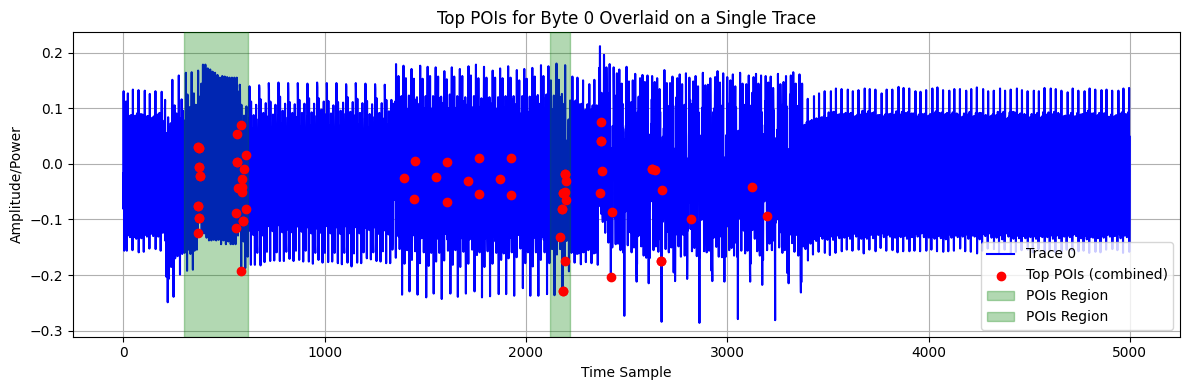

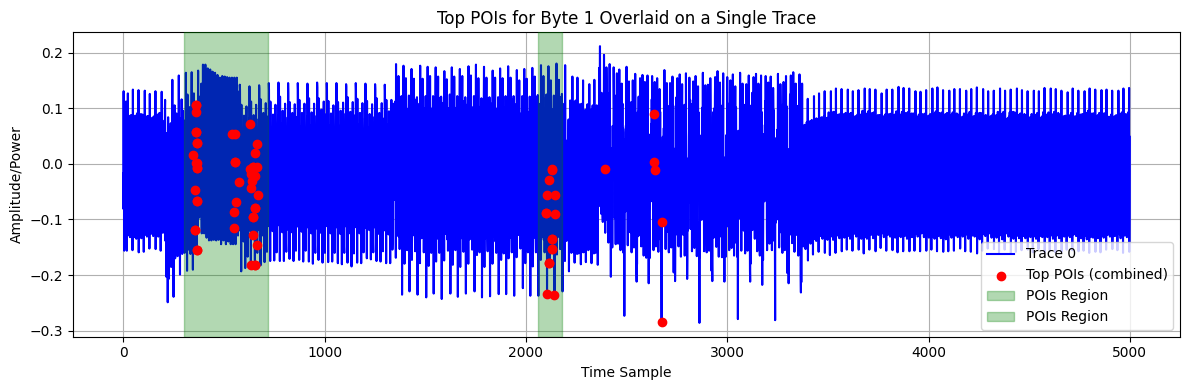

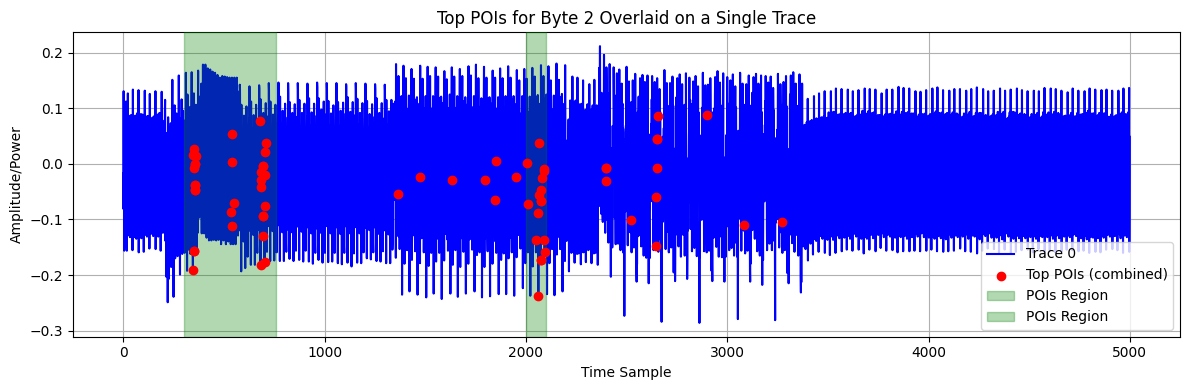

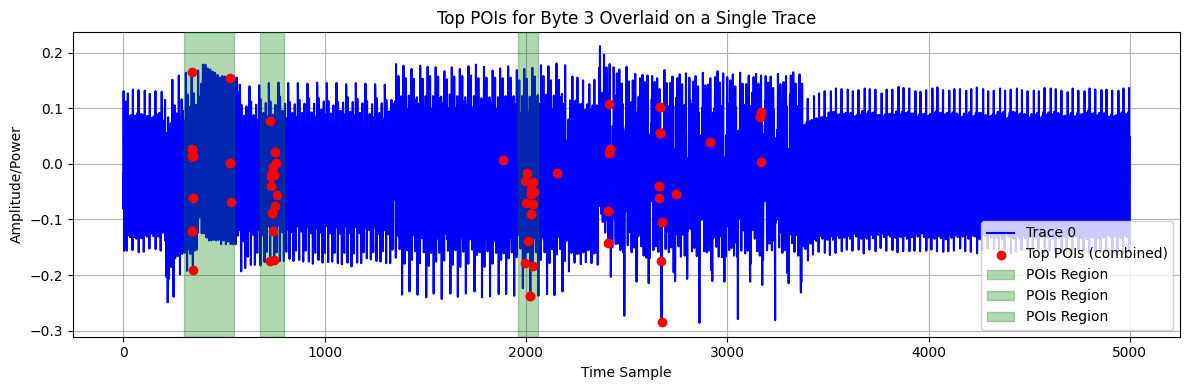

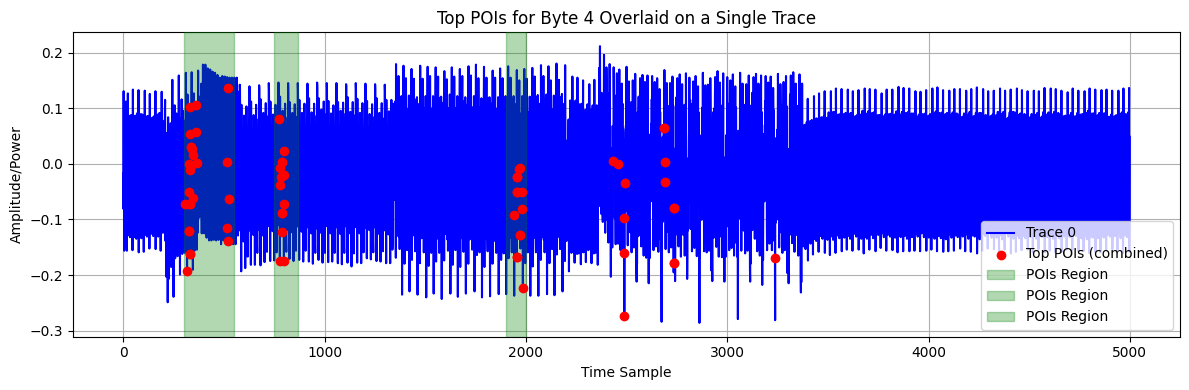

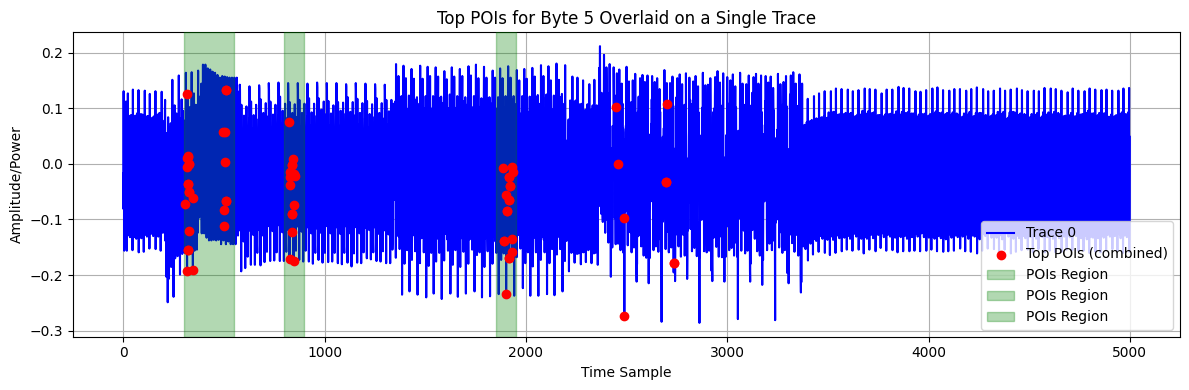

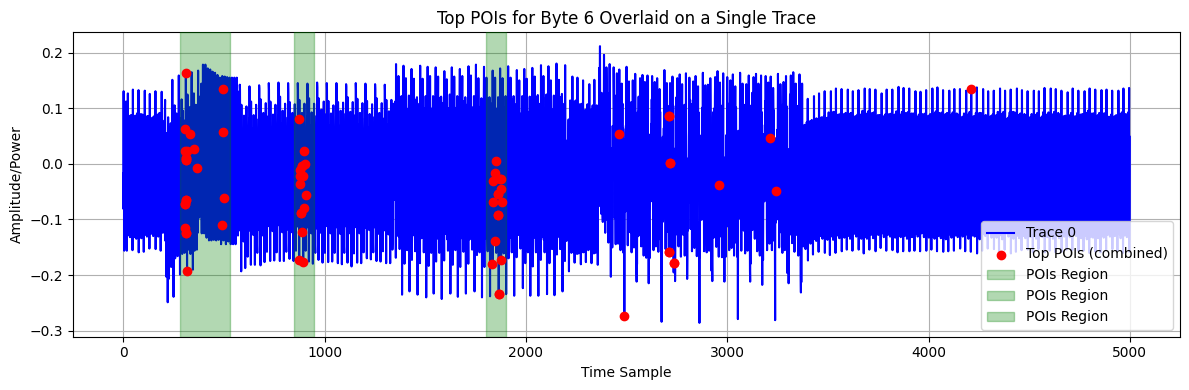

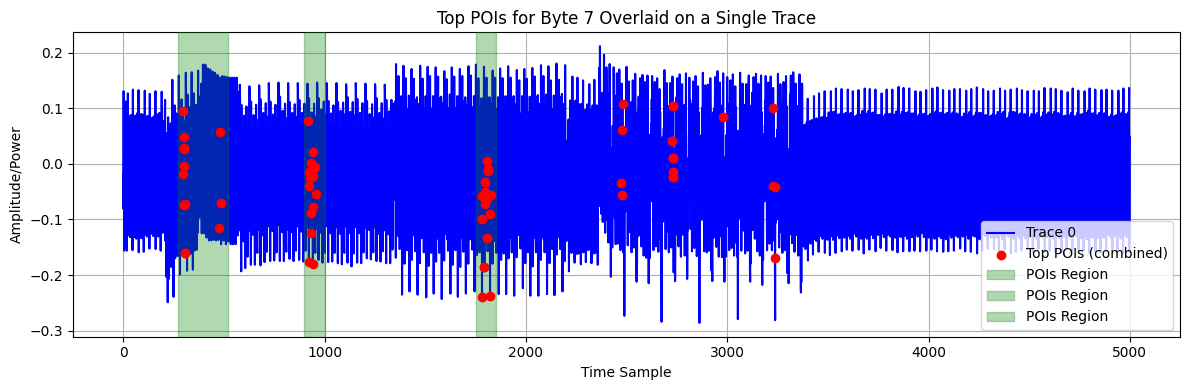

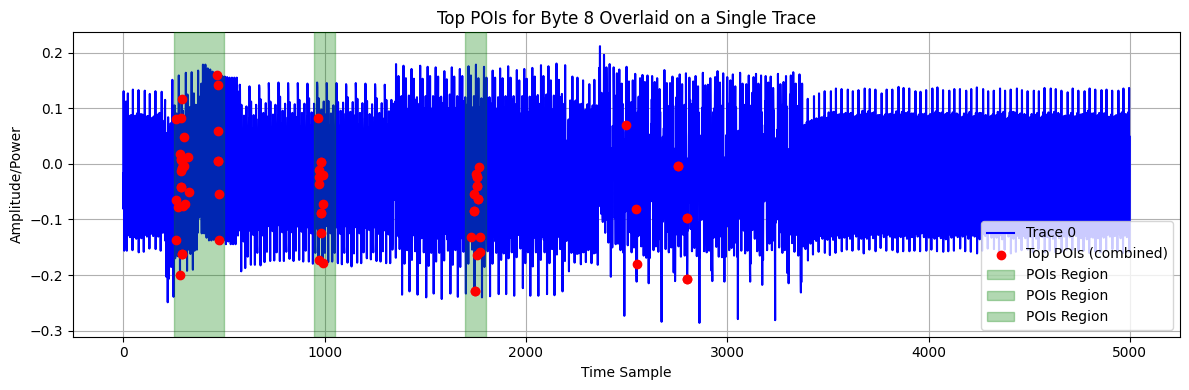

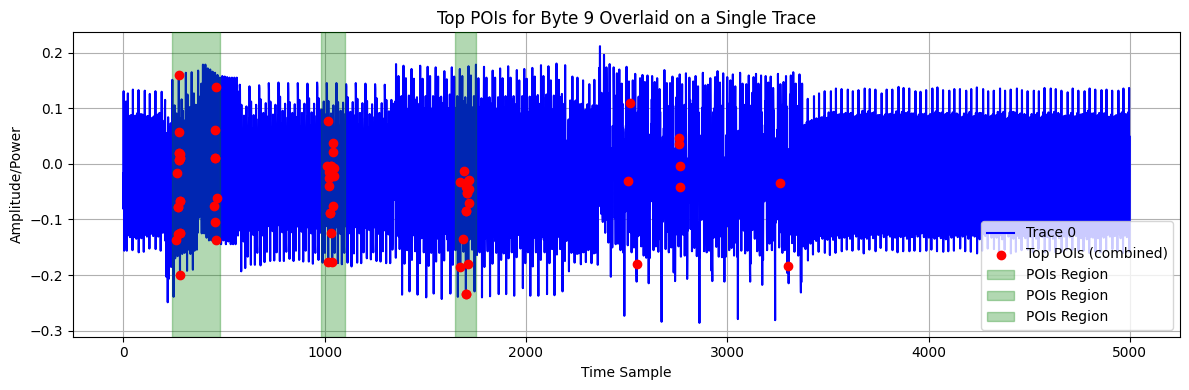

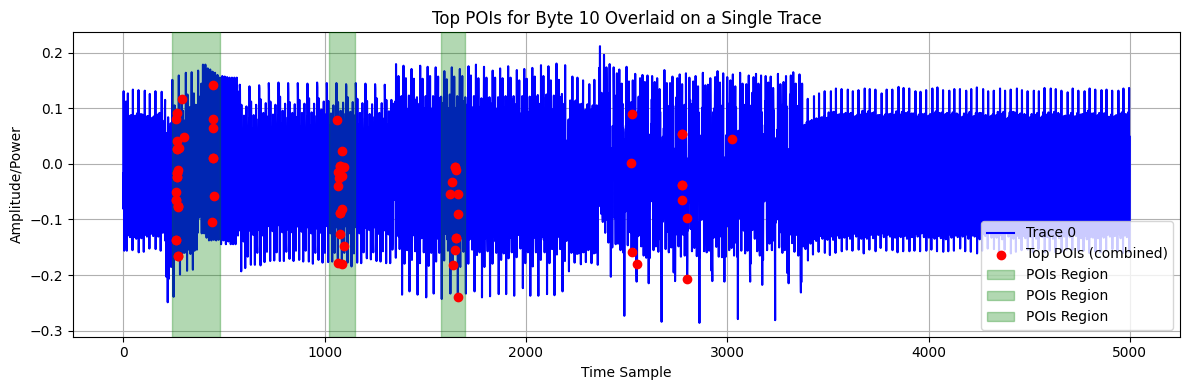

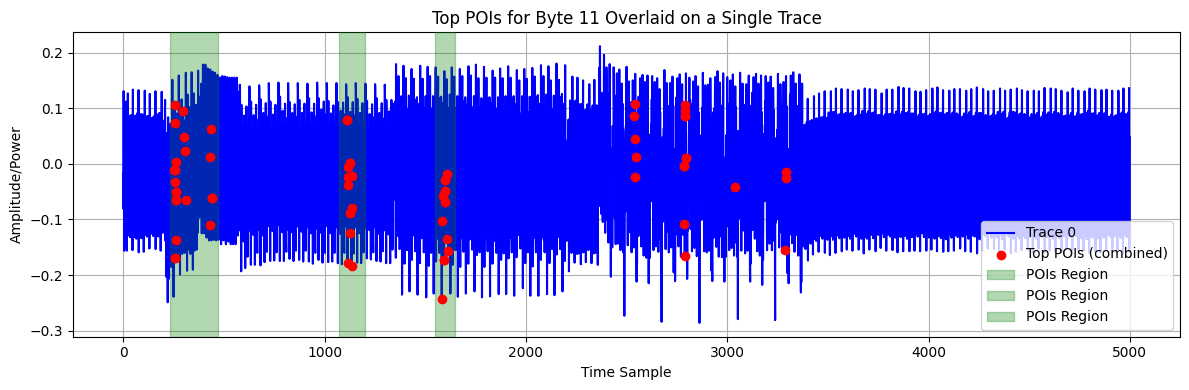

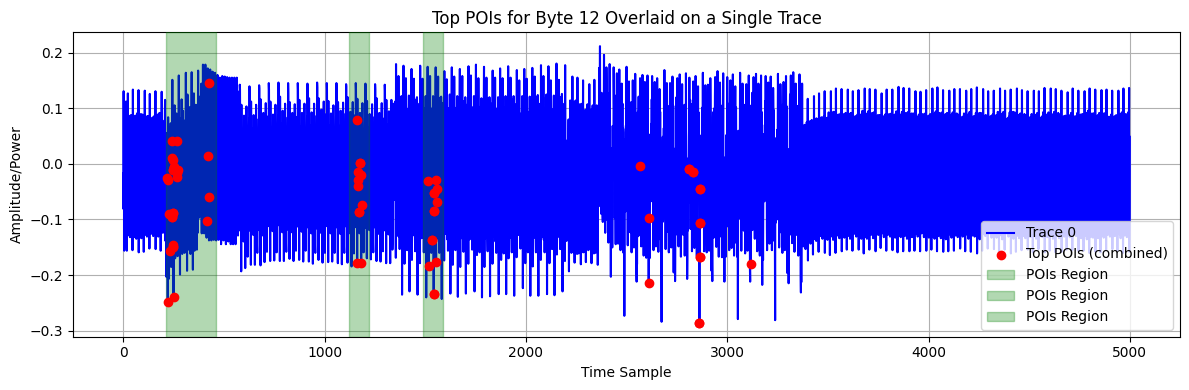

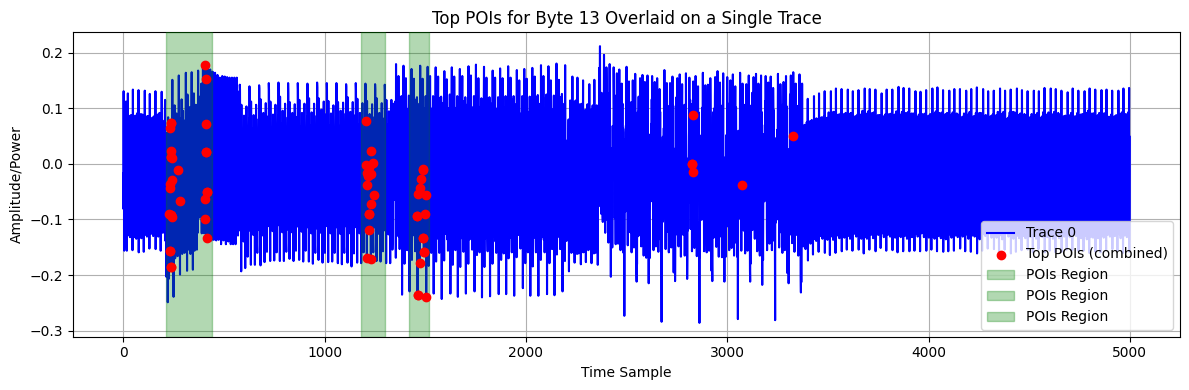

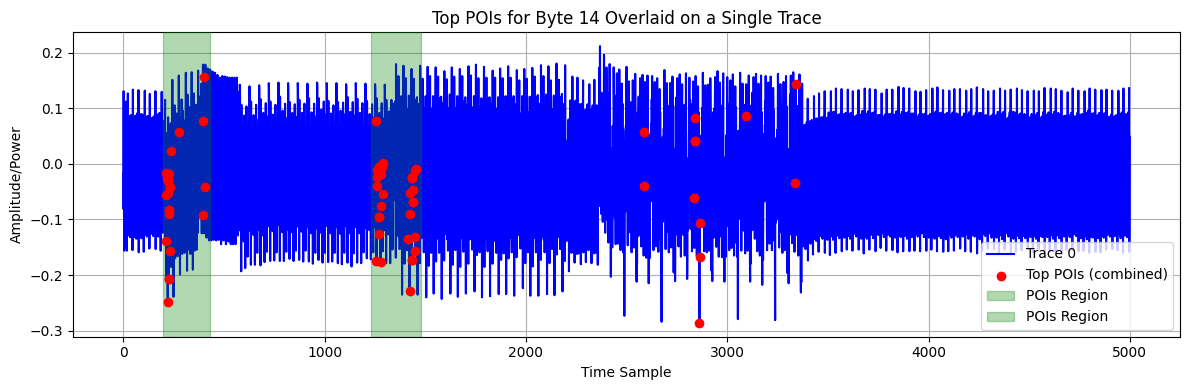

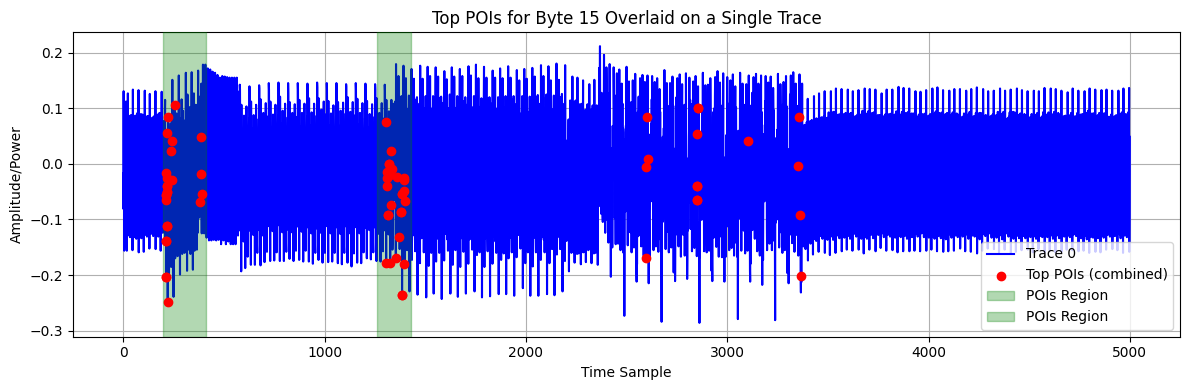

In [29]:
for idx, ranges_list in ranges["per_nibble"].items():
    poi_indices = []
    byte = int(idx)
    snr_top = np.argsort(result_aes[byte]['snr'])[-35:]
    hw_top = np.argsort(result_aes[byte]['correlation'])[-35:]

    poi_indices.extend(snr_top)
    poi_indices.extend(hw_top)

    global_pois.extend(poi_indices)

    unique_pois = sorted(set(poi_indices))

    # Plot the trace
    plt.figure(figsize=(12, 4))
    plt.plot(trace, label=f"Trace {trace_index}", color='blue')

    # Mark POIs
    plt.scatter(poi_indices, trace[poi_indices], color='red', zorder=5, label="Top POIs (combined)")
    plt.title(f"Top POIs for Byte {byte} Overlaid on a Single Trace")
    plt.xlabel("Time Sample")
    plt.ylabel("Amplitude/Power")
    for item in enumerate(ranges_list):
        _range = item[1]
        plt.axvspan(_range[0], _range[1], color='green', alpha=0.3, label="POIs Region", zorder=3)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Hypothesis Conclusion
The results from our signal-to-noise ratio (SNR) and Pearson correlation analyses confirm the presence of statistically significant leakage in specific time samples of the power traces. These leakage points correlate strongly with intermediate values of the cipher's internal state, particularly the SBox outputs, thereby validating the hypothesis that side-channel information leakage is detectable and quantifiable in the recorded traces.